In [1]:
### Allen B Davis
### Yale University
###
### First year project
### Summer 2015

# RVOS will create RV observations of a star with several planets, create a periodogram with FAP,
# fit a Keplerian, and return uncertainties in the planet's mass and orbital parameters

In [2]:
# Imports
import sys
import numpy as np
import math
# import matplotlib
# import matplotlib.pyplot as plt
# import pandas as pd
import scipy as sp
import scipy.signal
from astroML.time_series import \
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import pickle
# from lmfit import minimize, Parameters, Parameter, report_fit
from time import strftime
# import os
# import errno

import RVOS_io
from RVOS_Bodies import *
from RVOS_Constants import *
from RVOS_Observer import observeStar
from RVOS_Orbit import calcTrueAnomaly, fitOrbits
from RVOS_Plotter import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


try:
    rvos_title_file = open('title_art.txt', 'r')
    rvos_str = rvos_title_file.read()
    rvos_title_file.close()
except IOError:
    pass

plt.close()

C:\Users\Allen\AppData\Local\Enthought\Canopy\User\lib\site-packages\astroML\time_series\periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
def saveParams(sim,saveSim=False):
    #FIX FOR MULTIPLE PLANETS
    p = sim.planet
    
    # Planet's parameters
    inj_str = ("\nInjected parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
              "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
              "\nSemiamplitude = {4:.2f} m/s\nMass = {5:.2f} M_e").format(*p.params_print)
    fit_str = ("\nFitted parameters:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
              "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} deg"
              "\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e").format(*p.params_out_print)
    if sim.find_uncs:
        unc_str = ("\n1-sigma uncertainties:\nPeriod = {0:.4f} days\nEccentricity = {1:.3f}"
                  "\nPeriastron Time = {2:.3f} (days-t0)\nArgument of Periastron = {3:.2f} rad"
                  "\nSemiamplitude = {4:.2f} m/s\nMsini = {5:.2f} M_e").format(*p.uncs)
            
    # Print, if requested (default)
    if sim.verbose:
        print inj_str
        print fit_str
        if sim.find_uncs: print unc_str
        sys.stdout.flush()
        
    # Save to text file if requested
    if sim.saveObs:
    
        f = open(sim.saveObs+'_'+sim.theTime+'.txt','w')

        f.write(inj_str+'\n'+fit_str+'\n')
        if sim.find_uncs:
            f.write(unc_str+'\n')

        f.write('-------------------\n')
        f.write('JD,RV_True,RV_Obs\n')
        for i in range(0,np.size(p.RV_Obs)):
            f.write(str(p.obsList[i])+','+str(p.RV_True[i])+','+str(p.RV_Obs[i])+'\n')
        
    
    # Save the sim to a pickle
    if saveSim:
        fpkl = open('sim_'+sim.theDate+'_'+sim.theTime+'.pkl','w')
        pickle.dump(sim,fpkl)

In [4]:
# ### Solving orbit with LMfit

# def fitOrbits(star,P_G,periodList,obs_data,niter,n_pls=None,guesses=None,ignorePeriods=None,perThres=None,flag=None):
    
#     # Get number of planets to be fit
#     if n_pls == None:
#         n_pls = np.size(star.planets)
    
#     # Define objective function: returns the array to be minimized
#     def func(params, t, data):
#         # Arrays that will one parameter for each planet
#         P = [None]*n_pls
#         e = [None]*n_pls
#         tp = [None]*n_pls
#         h = [None]*n_pls
#         c = [None]*n_pls
#         f = [None]*n_pls
        
#         # Deal with each planet
#         for i in range(0,n_pls):
#             tag = str(i)
#             P[i] = params['P'+tag].value
#             e[i] = params['e'+tag].value
#             tp[i] = params['tp'+tag].value
#             h[i] = params['h'+tag].value
#             c[i] = params['c'+tag].value
#             f[i] = calcTrueAnomaly(P[i], tp[i], e[i], t)

#         assert not None in P and not None in e and not None in tp and not None in h and not None in c and not None in f, \
#             "None-type object still in at least one of the parameter arrays"
        
#         # Start with one planet, then add on any others
#         model = h[0]*np.cos(f[0]) + c[0]*np.sin(f[0])
#         for i in range(1,n_pls):
#             model += h[i]*np.cos(f[i]) + c[i]*np.sin(f[i])
#         model += params['v0'].value #constant offset
        
#         return model - data
    
    
#     # Initialize array of parameters
#     params_array = [None]*niter
#     result_array = [None]*niter
#     chisq_array = [None]*niter
    
#     # Generate list of period peaks sorted by periodogram power
#     PG_copy = np.copy(P_G) #make copies so originals aren't mutated by sorting/zipping
#     pers_copy = np.copy(periodList) #make copies so originals aren't mutated by sorting/zipping
#     PG_peaks = [pers_copy for (PG_copy,pers_copy) in sorted(zip(PG_copy,pers_copy))] #periods in order of ascending pgram power
#     maxima_pers = periodList[np.r_[True, P_G[1:] > P_G[:-1]] & np.r_[P_G[:-1] > P_G[1:], True]] #finds periods that are local maxima
#     toRemove = set(PG_peaks) ^ set(maxima_pers) #prepare to remove periods that are not in both arrays (^ = XOR)
#     for el in toRemove:
#         try: PG_peaks.remove(el)
#         except ValueError: pass
    
#     # Now turning PG_peaks into a numpy array. I know it's kludgy, but I cannot make remove work for it.
#     # And the np.where() only works on numpy arrays.
#     PG_peaks = np.array(PG_peaks)
    
#     # Exclude peaks we want to ignore for fitting
#     if not ignorePeriods == None:
        
#         assert type(ignorePeriods) is list and \
#         [np.size(el) for el in ignorePeriods] == [2]*(np.size(ignorePeriods)/2),\
#         'ignorePeriods must be of the form: [[min,max],[mix,max],...].'
        
#         for pair in ignorePeriods:
#             minval,maxval=pair[0],pair[1]
#             sys.stdout.flush()
#             PG_peaks = PG_peaks[np.where((PG_peaks<minval) | (PG_peaks>maxval))]
        
#     topNguesses = PG_peaks[-n_pls:]
    
#     # Do a bunch of fits
#     for n in range(0,niter):
#         # Choose some periods to guess for each planet
#         p_guesses = np.copy(topNguesses)
#         np.random.shuffle(p_guesses)
#         params = Parameters()
#         for m in range(0,n_pls):
#             # Create a set of Parameters
#             tag = str(m)
#             if perThres == None:
#                 params.add('P'+tag, value= p_guesses[m], min=0)
#             else:
#                 params.add('P'+tag, value= p_guesses[m], min=p_guesses[m]*(1-perThres), max=p_guesses[m]*(1+perThres))
#             params.add('e'+tag, value= 0.7*np.random.random(), min=0, max=1)
#             params.add('tp'+tag, value= star.t0+(np.random.random()*p_guesses[m]))
#             params.add('h'+tag, value= 4.*np.random.random()-2.)
#             params.add('c'+tag, value= 4.*np.random.random()-2.)
       
#         params.add('v0', value= 0.5*np.random.random()-0.25) #offset parameter; just 1 of these

#         # Do fit, here with leastsq model
#         result = minimize(func, params, args=(star.obsList, obs_data))
        
#         # Get chisq, which we will use to decide if this is the best fit
#         chisq = np.sum(result.residual**2)
        
#         # Save params, result, and chisq
#         params_array[n] = params
#         result_array[n] = result
#         chisq_array[n] = chisq
    
#     # Continue, now using the best fit according to chisq
#     n_best = np.argmin(chisq_array)
#     params = params_array[n_best]
#     result = result_array[n_best]
    
#     # Calculate final result
#     final = obs_data + result.residual
    
#     # Write error report
#     #report_fit(params)
    
#     # Fitted params = [P,e,tp,h,c]*n_pls + v0
#     # For each planet, extract the astrophysical parameters from the fit and save them
#     p_opt = [None]*n_pls
#     e_opt = [None]*n_pls
#     tp_opt = [None]*n_pls
#     w_opt = [None]*n_pls
#     K_opt = [None]*n_pls
#     msini_fit = [None]*n_pls
#     params_out = [None]*n_pls
#     RV_fit_pl = [None]*n_pls #one planet's component of the total RV fit
    
#     for m in range(0,n_pls):
#         tag = str(m)
#         p_opt[m] = params['P'+tag].value
#         e_opt[m] = params['e'+tag].value
#         tp_opt[m] = params['tp'+tag].value % p_opt[m] # take the first tp in the observation window for consistency
#         w_opt[m] = (np.arctan(-params['c'+tag].value/params['h'+tag].value))%(2.*pi) #[0-2pi) rads
        
#         # Ensure that the sign of Sin(w) == the sign of the numerator: -c
#         # Deals with the ambiguity in taking the arctan, above.
#         # This is a condition specified by Wright & Howard 2009
#         if not np.sign(np.sin(w_opt[m])) == np.sign(-params['c'+tag].value):
#             w_opt[m] = (w_opt[m]-pi)%(2.*pi)

#         K_opt[m] = np.sqrt(params['h'+tag].value**2 + params['c'+tag].value**2)
#         msini_fit[m] = (1./mEarth) * (K_opt[m]) * ((2.*pi*G/(p_opt[m]*day))**(-1./3.)) * ((star.massStar*mSun)**(2./3.)) * (np.sqrt(1-e_opt[m]**2.))

#         params_out[m] = np.array([p_opt[m],e_opt[m],tp_opt[m],w_opt[m],K_opt[m],msini_fit[m]])
        

#         f_opt = calcTrueAnomaly(p_opt[m],tp_opt[m],e_opt[m],star.obsList) #this is a temp variable, so not saved in an array
#         RV_fit_pl[m] = K_opt[m]*(np.cos(w_opt[m]+f_opt) + e_opt[m]*np.cos(w_opt[m]))
    
#     assert not None in p_opt and not None in e_opt and not None in tp_opt and not None in w_opt\
#     and not None in K_opt and not None in msini_fit and not None in params_out and not None in RV_fit_pl,\
#     "None-type object still in at least one of the parameter arrays after fitting."
    
#     RV_fit = np.sum(RV_fit_pl,axis=0) #total fitted RV
        
#     if "boot" == flag:
#         return params_out
#     else:
#         star.planets_fit = [None]*n_pls
#         for i in range(0,n_pls):
#             p = Planet(star,msini_fit[i],p_opt[i],e_opt[i],90.,w_opt[i],tp_opt[i],isReal=False)
#             star.planets_fit[i] = p
#         star.nPlanets_fit = n_pls
#         star.RV_fit = RV_fit
#         star.params_out = params_out
#         star.params_out_print = np.array([p_opt,e_opt,tp_opt,np.array(w_opt)*180./pi,K_opt,msini_fit])
#         star.params_LMfit = params

In [5]:
# Determine FAP by drawing from the sampled velocities
def bootstrap_FAP(star,freqList,niter):

    max_powers = [float]*niter #contains max power of each iteration

    RV_Obs_scram = np.copy(star.RV_Obs) #initialize
    size = len(RV_Obs_scram)
    for n in range(0,niter):

        # Drawing randomly with replacement (bootstrap)
        for m in range(0,size):
            ind = size*np.random.random()
            RV_Obs_scram[m] = star.RV_Obs[ind]

        # periodogram; max power
        P_G = sp.signal.lombscargle(star.obsList, RV_Obs_scram, freqList)
        max_powers[n] = max(P_G)

    return np.sort(max_powers) #[lowest...highest]
    

# Returns the periodogram power corresponding to the given FAP (in percent)
def calc_FAP_power(powers,FAP):
    size = len(powers) #assumes sorted [lowest...highest]
    
    if FAP*size < 100:
        print 'WARNING: Too few iterations (%d) to accurately report FAP of %.2f%%' %(size,FAP)

    index = (size-1) - (size*FAP/100.)
    
    if index != int(index):
        print 'WARNING: Requested FAP (%.2f%%) has been approximated to a nearby (and unknown) percentile' %FAP
        
    return powers[index] #this is a numpy array, so index m.n = index m

In [6]:
def bootstrap_Keplerian(star,P_G,periodList,boot_niter,orbit_niter):
    size = np.size(star.RV_fit)
    fit0 = np.copy(star.RV_fit)
    data = np.copy(star.RV_Obs)

    boot_params = [[float]*6]*boot_niter #stores each iteration's params: [P,e,tp,w,K,msini]
    
    #take the fit and subtract from the data
    resids = star.RV_Obs - fit0
        
    for n in range(0,boot_niter):
        
        #randomly draw from the residuals and add them to the original fit
        new_resids = [resids[np.random.randint(0,size)] for _ in range(0,size)]
        new_data = fit0 + new_resids

        #fit this function and save the parameters    
        new_params = fitOrbits(star,star.P_G,periodList,new_data,orbit_niter,flag="boot")
        boot_params[n] = new_params

    return np.array(boot_params)


def getUncs(star):
    #expects numpy array for "where" function
    
    w = star.params_out[3]
    ws = star.boot_params[:,3]
    
    if w < pi:
        locs = np.where(ws > w+pi)
        ws[locs] = ws[locs]-(2*pi)
    else:
        locs = np.where(ws < w-pi)
        ws[locs] = ws[locs]+(2*pi)
    
    uncs = np.std(star.boot_params,axis=0) #correct for all but w
    
    # overwrite temp with correct std value for W
    uncs[3] = np.std(ws)
    
    return uncs
    

In [7]:
# With RVOS now supporting multiple planets, is it clear that it will be too cumbersome to specify every planetary parameter
# in the Simulator call. I will adapt RVOS to run off of an external control file, but this will take some time to implement.
# For now, planetary parameters must be specified explicitly. "params_in" will be of the form:
# [[mass1,period1,ecc1,incl1,w1,tp],[mass2,period2,...],...]. Single planets must still be called in a nested list.

class Simulator:
    def __init__(self,nobs,sigma,
                 jitter=0.0,massStar=1.0,
                 params_in=[[10.,50.47,0.2,90.,None,None],[4.,13.37,0.4,90.,None,None]],
                 t0=today,
                 lat=34.7444,lng=-111.4222,ra=293.35647,dec=21.84033,
                 t_res = 10.,objAltThres=40.,weather=0.8,
                 saveObs='',loadObs='',
                 loadStar=None,loadPlanets=None,
                 pmin=0.1,pmax=500.,pres=0.01,pgram='astroML',
                 ignorePeriods=[[0.8,1.2]],perThres=0.05,sortKey='period',
                 find_FAP=True,FAP_levels=[1,5],threshold_FAP=1.0,FAP_niter=100,FAP_method='astroML',
                 orbit_niter=100,boot_niter=100,find_uncs=True,abort_bad_fits=True,
                 verbose=True):

        self.nobs = nobs #number of observations proposed (modulo weather)
        self.sigma = sigma
        self.std_True = np.sqrt(sigma**2 + jitter**2)
        self.periodList = np.linspace(pmin,pmax,num=pmax/pres)
        self.freqList = 2.* pi / self.periodList
        
        self.t_res = t_res
        self.weather = weather
        
        self.loadStar = loadStar
        self.loadPlanets = loadPlanets
        
        self.params_in = params_in
        nPlanets=np.size(params_in,axis=0)
        
        self.find_FAP = find_FAP
        self.FAP_levels = FAP_levels
        self.FAP_niter = FAP_niter
        self.FAP_method = FAP_method
        
        self.find_uncs = find_uncs
        self.abort_bad_fits = abort_bad_fits
        self.boot_niter = boot_niter
        
        self.loc = EarthLocation.from_geodetic(lng,lat) # Discovery Channel Telescope by default

        self.coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree) #HIP 96183 by default
        starname = 'HIP 96183'

        self.theDate = strftime("%Y-%m-%d")
        self.theTime = strftime("%H-%M-%S")
        
        self.saveObs = saveObs
        
        self.verbose = verbose
            
            
        ###### Run simulation
        
        # Create a star
        if not self.loadStar == None:
            print strftime("%H:%M:%S"),'-- Loading star'
            sys.stdout.flush()
            assert loadPlanets == None,'Cannot load both star and planets; star has at least one planet!'
            assert self.loadStar.typecheck is 'Star','loadStar must be a Star object that was created by RVOS previously.'
            star = loadStar
        else:
            print strftime("%H:%M:%S"),'-- Creating star'
            sys.stdout.flush()
            star = Star(massStar,t0,self.coord,sigma,planets=None,name=starname)
            star.nPlanets = nPlanets
        
        # Create some planet objects with given astrophysical parameters
        if not self.loadPlanets == None:
            print strftime("%H:%M:%S"),'-- Loading planet(s)'
            sys.stdout.flush()
            assert np.all([self.loadPlanets[p].typecheck == 'Planet' for p in self.loadPlanets]),\
            'loadPlanets must be a list of Planet objects that were created by RVOS previously.'
            planets = loadPlanets
        else:
            print strftime("%H:%M:%S"),'-- Creating planet(s)'
            sys.stdout.flush()
            assert nPlanets > 0,'Must be a positive, non-zero, number of planets.'
            assert nPlanets < 5,'%d planets? Are you trying to blow up the computer?!? RVOS can probably handle up to 4.' %nPlanets
            planets = [None]*nPlanets
            for i in range(0,nPlanets):
                pars = self.params_in[i]
                planets[i] = Planet(star,pars[0],pars[1],pars[2],pars[3],pars[4],pars[5])
            star.planets = planets
        # Sort planets by sort key if provided
        if not sortKey == None:
            star.planets = sortPlanets(star.planets,sortKey)
            if not star.name == '':
                for i in range(0,star.nPlanets):
                    p = star.planets[i]
                    p.name += chr(i+ord('b'))
            
        # Create observations according to blind survey strategy
        print strftime("%H:%M:%S"),'-- Observing star'
        sys.stdout.flush()
        observeStar(star,nobs,self.std_True,t0,self.coord,self.loc,self.t_res,objAltThres,weather)
        # Save observations if requested
        if saveObs:
            f = open(saveObs+'_'+self.theTime+'.txt','w')
            f.write('JD,RV_True,RV_Obs\n')
            for i in range(0,np.size(star.RV_Obs)):
                f.write(str(star.obsList[i])+','+str(star.RV_True[i])+','+str(star.RV_Obs[i])+'\n')
        
        # Make a LS periodogram of the observations
        assert pgram=='scipy' or pgram=='astroML' or pgram=='astroml',\
            "pgram parameter must be set to either 'scipy' or 'astroML'."
            
        if pgram == 'scipy':
            star.P_G = sp.signal.lombscargle(star.obsList, star.RV_Obs,self.freqList)
        elif pgram == 'astroML' or pgram == 'astroml':
            star.P_G = lomb_scargle(star.obsList, star.RV_Obs, sigma, self.freqList, generalized=True)
            
        
        # Find FAP levels by bootstrapping
        if self.find_FAP:
            print strftime("%H:%M:%S"),'-- Bootstrapping for FAP'
            sys.stdout.flush()
            
            
            if not FAP_method=='astroML' or not FAP_method=='astroml':
                max_powers_sort = bootstrap_FAP(star,self.freqList,FAP_niter)

                star.FAP_powers = [[float]*2]*len(FAP_levels) #set of ordered pairs: [[FAP lvl, power],...]
                for n in range(0,len(star.FAP_powers)):
                    lvl = FAP_levels[n]
                    power = calc_FAP_power(max_powers_sort,lvl)
                    star.FAP_powers[n] = lvl,power
            else:
                D_cf = lomb_scargle_bootstrap(star.obsList, star.RV_Obs, sigma, self.freqList, generalized=True,
                                              N_bootstraps=1000, random_state=0)
                sig_cf = []
                for lvl in FAP_levels:
                    sig_cf.append(np.percentile(D_cf,100-lvl))
                star.FAP_powers = zip(FAP_levels,sig_cf) #tuple of (FAP level in %, power level)
                                                         #e.g., (0.1,0.8)
                
        # Fit Keplerian to determine orbital parameters
        print strftime("%H:%M:%S"),'-- Fitting Keplerian'
        sys.stdout.flush()
        fitOrbits(star,star.P_G,self.periodList,star.RV_Obs,orbit_niter,ignorePeriods=ignorePeriods,perThres=perThres)
        if not sortKey == None:
            star.planets_fit = sortPlanets(star.planets_fit,sortKey)
            if not star.name == '':
                for i in range(0,star.nPlanets_fit):
                    p = star.planets_fit[i]
                    p.name += chr(i+ord('b'))
        
        # Determine whether the period is sufficiently close to the real period to decide if we should
        # bother finding uncertainties
        if self.find_uncs and self.abort_bad_fits:
            for i in range(0,nPlanets):
                p = planets[i]
                tag = str(i)
                p_ratio = p.period/p.params_LMfit['P'+tag]
                if not (0.9 < p_ratio < 1.1):
                    # Abort finding uncertainties if the period is >|10%| wrong
                    self.find_uncs = False
                    print strftime("%H:%M:%S"),'-- Uncertainties bootstrapping aborted: period fit is poor'
                    break
        
        # Calculate uncertainties in fitted parameters
        if self.find_uncs:
            print strftime("%H:%M:%S"),'-- Bootstrapping for uncertainties'
            sys.stdout.flush()
            star.boot_params = bootstrap_Keplerian(star,star.P_G,self.periodList,boot_niter,orbit_niter)
            star.uncs = getUncs(star) 
            
        print strftime("%H:%M:%S"),'-- Simulation complete'
        sys.stdout.flush()
        
        # Save everything
        RVOS_io.SaveSystem(star,planets)

        
        # Save star
        self.star = star

In [8]:
def sortPlanets(planets,sortKey):
    p = planets[0]
    planet_tuples = [(p,p.period,p.mass,p.ecc)]
    for i in range(1,np.size(planets)):
        p = planets[i]
        planet_tuples.append((p,p.period,p.mass,p.ecc,p.K))
    
    keys = {'period':1,'per':1,'p':1,
            'mass':2,'msini':2,'m':2,
            'eccentricity':3,'ecc':3,'e':3,
            'k':4,'K':4,'semiamplitude':4,'amplitude':4}
    
    ind = keys.get(sortKey,None)
    assert not ind == None,'Requested sortKey (%s) is currently unsupported'%sortKey
    
    sortedTuples = sorted(planet_tuples, key=lambda tup: tup[ind])
    return [sortedTuples[i][0] for i in range(0,np.size(sortedTuples,axis=0))]

In [9]:
# Useful for finding the separation between observations, ignoring seasonal gaps
def medianSep(arr):
    seps = []
    for n in range(0,np.size(arr)-1):
        cur = arr[n]
        nxt = arr[n+1]
        seps = np.append(seps,nxt-cur)
    return np.median(seps)

In [10]:
def eccDistrib(n,center=0.3,stdev=0.05):
    # Default values based on fig 5 of Hogg, Myers, Bovy 2010
    x = np.array([np.random.normal(loc=center,scale=stdev) for _ in range(0,n)])
    badlocs = np.where((x>0) | (x>=1))
    size = np.size(badlocs)

    while(not size == 0):
        newvals = np.array([np.random.normal(loc=0.3,scale=0.2) for _ in range(0,size)])
        x[badlocs] = newvals
        badlocs = np.where((x<0) | (x>=1))
        size = np.size(badlocs)
    return x

In [30]:
#### RUN ME HERE

iters = 1
sims = [None]*iters #store sims for later referencing
eccs = eccDistrib(iters)

try:
    tmp = rvos_str
    print 'Welcome to'
    print rvos_str
    sys.stdout.flush()
except NameError:
    print 'Welcome to RVOS'

    
for n in range(0,iters):
    plt.close()
    
    print '\n********* STAR SYSTEM %d *********' %(n+1)
    sys.stdout.flush()
    sim = Simulator(200,0.2,perThres=0.05,massStar=0.8,
                    params_in=[[10.,34.47,0.24,90.,None,None],
                               [7.,77.12,0.37,90.,None,None]
                              ],objAltThres=50.,ignorePeriods=[[0,5]],
                     boot_niter=100,FAP_levels=[1.0],FAP_niter=100,find_FAP=False,find_uncs=False,abort_bad_fits=True,saveObs='')
#     saveParams(sim,saveSim=True)
    makePlot(sim,save=str(n+1)+'modules',fmt='png,pdf')
    sims[n] = sim
    plt.close()


Welcome to
         _     _          _       _            _        
        /\ \  /\ \    _ / /\     /\ \         / /\      
       /  \ \ \ \ \  /_/ / /    /  \ \       / /  \     
      / /\ \ \ \ \ \ \___\/    / /\ \ \     / / /\ \__  
     / / /\ \_\/ / /  \ \ \   / / /\ \ \   / / /\ \___\ 
    / / /_/ / /\ \ \   \_\ \ / / /  \ \_\  \ \ \ \/___/ 
   / / /__\/ /  \ \ \  / / // / /   / / /   \ \ \       
  / / /_____/    \ \ \/ / // / /   / / /_    \ \ \      
 / / /\ \ \       \ \ \/ // / /___/ / //_/\__/ / /      
/ / /  \ \ \       \ \  // / /____\/ / \ \/___/ /       
\/_/    \_\/        \_\/ \/_________/   \_____\/     

********* STAR SYSTEM 1 *********
17:39:58 -- Creating star
17:39:58 -- Creating planet(s)
17:39:58 -- Observing star
17:41:21 -- Fitting Keplerian
17:42:01 -- Simulation complete


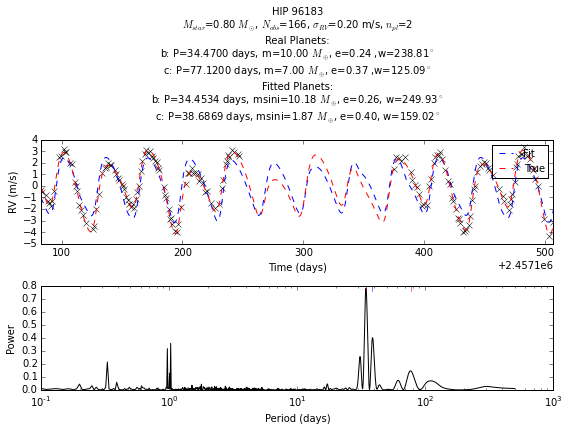

In [31]:
plt.close()
makePlot(sims[0])
plt.close()

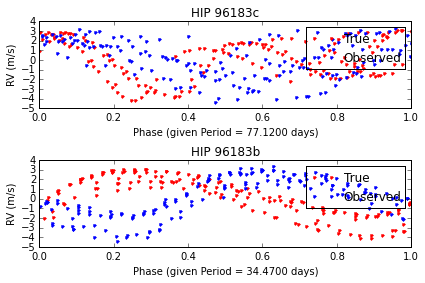

In [32]:
plt.close()
star = sims[0].star
makePhasePlot(star)
plt.close()

In [14]:
# print medianSep(sims[0].planet.obsList)

In [15]:
# f=open('sim1.pckl','wb')
# star = sims[0]
# pickle.dump(star,f)
# f.close()


In [16]:
# f = open('sim1.pckl','r')
# star = pickle.load(f)


# # Saving the objects:
# with open('objs.pickle', 'w') as f:
#     pickle.dump([obj0, obj1, obj2], f)

# # Getting back the objects:
# with open('sim1.pckl') as f:
#     star = pickle.load(f)
